## Neural Style Transfer

Source of Learning: [TensorFlow Tutorials](https://www.tensorflow.org/tutorials/generative/style_transfer)

### Importing Libraries

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as pimg
import os
from PIL import Image
from skimage.io import imread, imshow, imread_collection, concatenate_images
from tensorflow.keras.utils import plot_model,to_categorical
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Add, Input, Flatten,Embedding,LSTM,GlobalAveragePooling2D,Concatenate,Conv2D,BatchNormalization,LeakyReLU,ZeroPadding2D,UpSampling2D,MaxPooling2D

### Reading and Visualising Images

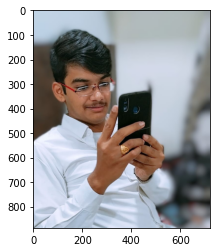

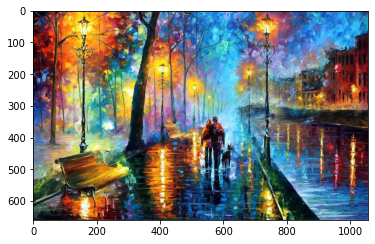

In [2]:
Image2 = pimg.imread('Style.jpg')
Image1 = pimg.imread('Me.jpg')

plt.imshow(Image1)
plt.show()
plt.imshow(Image2)
plt.show()

In [3]:
Content = Image1/255.0
Style = Image2/255.0

### Loss Functions and Gram Matrices

Gram Matrices are computed for Style parts

$G_{c d}^{l}=\frac{\sum_{i j} F_{i j c}^{l}(x) F_{i j d}^{l}(x)}{I J}$

In [4]:
def GramMatrix(style_output):
    Numerator = tf.linalg.einsum('bijc,bijd->bcd', style_output, style_output)
    input_shape = tf.shape(style_output)
    Denominator = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return Numerator/Denominator

Loss = $\alpha Loss_{Content} + \beta Loss_{Style}$

In [5]:
def LossFunction(Content_Output,Style_Output,Content_Target,Style_Target,nclayers,nslayers,alpha=1e4,beta=1e-3):

    # Style Loss
    style_loss = tf.add_n([tf.reduce_mean((Style_Output[name]-Style_Target[name])**2) 
                           for name in Style_Output.keys()])
    style_loss *= beta / nclayers


    # Content Loss
    content_loss = tf.add_n([tf.reduce_mean((Content_Output[name]-Content_Targets[name])**2) 
                             for name in Content_Output.keys()])    
    content_loss *= alpha / nslayers
    loss = style_loss + content_loss
    return loss

### Building a Model

Using VGG Model's Convolution Blocks for adding Style to Content

In [6]:
Content_Layers = ['block5_conv2'] 

Style_Layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

nclayers = len(Content_Layers)
nslayers = len(Style_Layers)

In [7]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

outputs = [vgg.get_layer(name).output for name in Content_Layers + Style_Layers]
StyleTransferModel = tf.keras.Model([vgg.input], outputs)

80142336/80134624 [==============================] - 1s 0us/step


In [8]:
def StyleContentExtractor(Input,Model):

    input = tf.expand_dims(Input,axis=0) * 255.0
    Model_Outputs = Model(input)

    Style_Outputs = {}
    Content_Outputs = {}

    i = 0
    for s in Style_Layers:
        Style_Outputs[s] = GramMatrix(Model_Outputs[i])
        i+=1

    for c in Content_Layers:
        Content_Outputs[c] = Model_Outputs[i]
        i+=1

    return Style_Outputs,Content_Outputs

In [9]:
Style_Targets = StyleContentExtractor(Style,StyleTransferModel)[0]
Content_Targets = StyleContentExtractor(Content,StyleTransferModel)[1]

### Training the Model

In [10]:
Optimizer = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

def Clipping(ImageData):
    return tf.clip_by_value(ImageData, clip_value_min=0.0, clip_value_max=1.0)

In [11]:
@tf.function()
def TrainingStep(ImageData):
    with tf.GradientTape() as tape:
        Style_Outputs, Content_Outputs = StyleContentExtractor(ImageData,StyleTransferModel)
        Loss = LossFunction(Content_Outputs,Style_Outputs,Content_Targets,Style_Targets,nclayers,nslayers)

    gradients = tape.gradient(Loss, ImageData)
    Optimizer.apply_gradients([(gradients, ImageData)])
    ImageData.assign(Clipping(ImageData))

In [12]:
ImageData = tf.Variable(Content)

In [13]:
def Training(Epochs,Steps_per_Epoch):
    for i in range(Epochs):
        print ('Epochs:',i)
        for j in range(Steps_per_Epoch):
            TrainingStep(ImageData)

In [14]:
Training(10,100)

Epochs: 0
Epochs: 1
Epochs: 2
Epochs: 3
Epochs: 4
Epochs: 5
Epochs: 6
Epochs: 7
Epochs: 8
Epochs: 9


### Image Generation

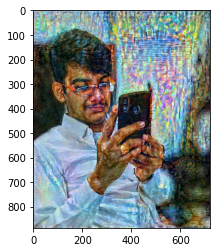

In [15]:
ImageNData = ImageData.numpy()
plt.imshow(ImageNData)

In [16]:
im = Image.fromarray(np.array(ImageNData*255,dtype=np.uint8))
im.save('Styled.png')